In [1]:
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from mxnet import autograd, nd, init, gluon
from mxnet.gluon import data as gdata
from mxnet.gluon import loss as gloss
from mxnet.gluon import nn, rnn
from time import time
import mxnet as mx
import numpy as np
import d2lzh as d2l
# import random
# import zipfile
import math
import time
# import sys 

# 07. 优化算法
在训练模型时，我们会使⽤优化算法不断迭代模型参数以降低模型损失函数的值。当迭代终⽌时，模型的训练随之终⽌，此时的模型参数就是模型通过训练所学习到的参数。

优化算法对于深度学习⼗分重要。⼀⽅⾯，训练⼀个复杂的深度学习模型可能需要数小时、数⽇，甚⾄数周时间，而优化算法的表现直接影响模型的训练效率；另⼀⽅⾯，理解各种优化算法的原理以及其中超参数的意义将有助于我们更有针对性地调参，从而使深度学习模型表现更好。

## 7.1 优化与深度学习
在一个深度学习问题中，我们通常会预先定义一个损失函数。有了损失函数以后，我们就可以使用优化算法试图将其最小化。在优化中，这样的损失函数通常被称作优化问题的目标函数(objective function)。

### 7.1.1 优化与深度学习的关系
虽然优化为深度学习提供了最小化损失函数的方法，但本质上，优化与深度学习的目标是有区别的。在`模型选择、欠拟合和过拟合`一节中，我们区分了训练误差和泛化误差。由于优化算法的目标函数通常是一个基于训练数据集的损失函数，优化的目标在于降低训练误差。而深度学习的目标在于降低泛化误差。为了降低泛化误差，除了使用优化算法降低训练误差以外，还需要注意应对过拟合。

本章中，我们只关注优化算法在最小化目标函数上的表现，而不关注模型的泛化误差。

### 7.1.2 优化在深度学习中的挑战
我们在`线性回归`一节中对优化问题的`解析解`和`数值解`做了区分。深度学习中绝大多数目标函数都很复杂，很多优化问题并不存在解析解，而需要使用基于数值方法的优化算法找到近似解，即数值解。本书中讨论的优化算法都是这类基于数值方法的算法。为了求得最小化目标函数的数值解，我们将通过优化算法有限次迭代模型参数来尽可能降低损失函数的值。

优化在深度学习中有很多挑战。下面描述了其中的两个挑战，即`局部最小值`和`鞍点`。

##### 局部最小值
对于目标函数$f(x)$，如果$f(x)$在$x$上的值比在$x$邻近的其他点的值更小，那么$f(x)$可能是一个`局部最小值`(local minimum)。如果$f(x)$在$x$上的值是目标函数在整个定义域上的最小值，那么$f(x)$是`全局最小值`(global minimum)。

举个例子，给定函数
+ $f(x) = x \cdot \text{cos}(\pi x), \qquad -1.0 \leq x \leq 2.0$

我们可以找出该函数的局部最小值和全局最小值的大致位置。

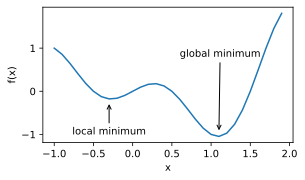

In [2]:
def f(x):
    return x * np.cos(np.pi * x)

d2l.set_figsize((4.5, 2.5))
x = np.arange(-1.0, 2.0, 0.1)
fig, = d2l.plt.plot(x, f(x)) # 逗号表⽰只取返回列表中的第⼀个元素
fig.axes.annotate('local minimum', xy=(-0.3, -0.25), xytext=(-0.77, -1.0), arrowprops=dict(arrowstyle='->'))
fig.axes.annotate('global minimum', xy=(1.1, -0.95), xytext=(0.6, 0.8), arrowprops=dict(arrowstyle='->')) 
d2l.plt.xlabel('x') 
d2l.plt.ylabel('f(x)')
plt.show()

深度学习模型的目标函数可能有若干局部最优值。当一个优化问题的数值解在局部最优解附近时，由于目标函数有关解的梯度接近或变成0，最终迭代求得的数值解可能只令目标函数局部最小化而非全局最小化。

##### 鞍点
梯度接近或变成0的另一种可能性是当前解在`鞍点`(saddle point)附近。

给定函数
+ $f(x) = x^3$

我们可以找出该函数的鞍点位置。

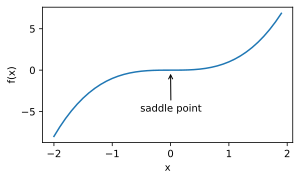

In [3]:
x = np.arange(-2.0, 2.0, 0.1) 
fig, = d2l.plt.plot(x, x**3)
fig.axes.annotate('saddle point', xy=(0, -0.2), xytext=(-0.52, -5.0), arrowprops=dict(arrowstyle='->')) 
d2l.plt.xlabel('x') 
d2l.plt.ylabel('f(x)')
plt.show()

再举个定义在二维空间的函数的例子，例如：
+ $f(x, y) = x^2 - y^2$

我们可以找出该函数的鞍点位置，该函数看起来像一个马鞍，而鞍点恰好是马鞍上可坐区域的中心。

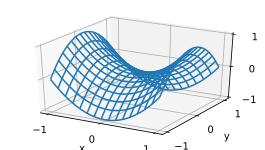

In [4]:
x, y = np.mgrid[-1: 1: 31j, -1: 1: 31j]
z = x**2 - y**2

ax = d2l.plt.figure().add_subplot(111, projection='3d') 
ax.plot_wireframe(x, y, z, **{'rstride': 2, 'cstride': 2}) 
ax.plot([0], [0], [0], 'rx')

ticks = [-1, 0, 1]

d2l.plt.xticks(ticks)
d2l.plt.yticks(ticks) 
ax.set_zticks(ticks) 
d2l.plt.xlabel('x') 
d2l.plt.ylabel('y')
plt.show()

在图的鞍点位置，目标函数在$x$轴方向上是局部最小值，但在$y$轴方向上是局部最大值。

假设一个函数的输入为$k$维向量，输出为标量，那么它的`海森矩阵`(Hessian matrix)有$k$个特征值。该函数在梯度为0的位置上可能是局部最小值、局部最大值或者鞍点：
+ 当函数的海森矩阵在梯度为0的位置上的特征值全为正时，该函数得到局部最小值
+ 当函数的海森矩阵在梯度为0的位置上的特征值全为负时，该函数得到局部最大值
+ 当函数的海森矩阵在梯度为0的位置上的特征值有正有负时，该函数得到鞍点

随机矩阵理论告诉我们，对于一个大的高斯随机矩阵来说，任一特征值是正或者是负的概率都是0.5。那么，以上第一种情况的概率为$0.5^k$。由于深度学习模型参数通常都是高维的($k$很大)，目标函数的鞍点通常比局部最小值更常见。

在深度学习中，虽然找到目标函数的全局最优解很难，但这并非必要。我们将在本章接下来的几节中逐一介绍深度学习中常用的优化算法，它们在很多实际问题中都能够训练出十分有效的深度学习模型。

## 7.2 梯度下降和随机梯度下降
虽然梯度下降在深度学习中很少被直接使用，但理解梯度的意义以及沿着梯度反方向更新自变量可能降低目标函数值的原因是学习后续优化算法的基础。

### 7.2.1 一维梯度下降
我们先以简单的一维梯度下降为例，解释梯度下降算法可能降低目标函数值的原因。

假设连续可导的函数$f: \mathbb{R} \rightarrow \mathbb{R}$的输入和输出都是标量。给定绝对值足够小的数$\epsilon$，根据泰勒展开公式，我们得到以下的近似：
+ $f(x + \epsilon) \approx f(x) + \epsilon f'(x) $

这里$f'(x)$是函数$f$在$x$处的梯度。一维函数的梯度是一个标量，也称导数。

接下来，找到一个常数$\eta > 0$，使得$\left|\eta f'(x)\right|$足够小，那么可以将$\epsilon$替换为$-\eta f'(x)$并得到
+ $f(x - \eta f'(x)) \approx f(x) - \eta f'(x)^2$

如果导数$f'(x) \neq 0$，那么$\eta f'(x)^2>0$，所以
+ $f(x - \eta f'(x)) \lesssim f(x)$

这意味着，如果通过
+ $x \leftarrow x - \eta f'(x)$

来迭代$x$，函数$f(x)$的值可能会降低。因此在梯度下降中，我们先选取一个初始值$x$和常数$\eta > 0$，然后不断通过上式来迭代$x$，直到达到停止条件，例如$f'(x)^2$的值已足够小或迭代次数已达到某个值。

下面我们以目标函数$f(x)=x^2$为例来看一看梯度下降是如何工作的。虽然我们知道最小化$f(x)$的解为$x=0$，这里依然使用这个简单函数来观察$x$是如何被迭代的。

使用$x=10$作为初始值，并设$\eta=0.2$。使用梯度下降对$x$迭代10次，可见最终$x$的值较接近最优解。

In [5]:
def gd(eta):
    x = 10 
    results = [x] 
    for i in range(10):
        x -= eta * 2 * x  # f(x) = x * x的导数为f'(x) = 2 * x
        results.append(x) 
    print('epoch 10, x:', x) 
    return results

res = gd(0.2)

epoch 10, x: 0.06046617599999997


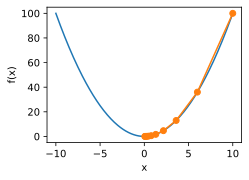

In [6]:
def show_trace(res):
    n = max(abs(min(res)), abs(max(res)), 10) 
    f_line = np.arange(-n, n, 0.1) 
    d2l.set_figsize() 
    d2l.plt.plot(f_line, [x * x for x in f_line]) 
    d2l.plt.plot(res, [x * x for x in res], '-o') 
    d2l.plt.xlabel('x') 
    d2l.plt.ylabel('f(x)')
    plt.show()

show_trace(res)

### 7.2.2 学习率
上述梯度下降算法中的正数$\eta$通常叫作学习率。这是一个超参数，需要人工设定。如果使用过小的学习率，会导致$x$更新缓慢从而需要更多的迭代才能得到较好的解。

下面展示使用学习率$\eta=0.05$时自变量$x$的迭代轨迹。可见，同样迭代10次后，当学习率过小时，最终$x$的值依然与最优解存在较大偏差。

epoch 10, x: 3.4867844009999995


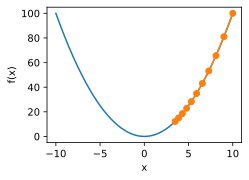

In [7]:
show_trace(gd(0.05))

如果使用过大的学习率，$\left|\eta f'(x)\right|$可能会过大从而使前面提到的一阶泰勒展开公式不再成立：这时我们无法保证迭代$x$会降低$f(x)$的值。

举个例子，当设学习率$\eta=1.1$时，可以看到$x$不断越过最优解$x=0$并逐渐发散。

epoch 10, x: 61.917364224000096


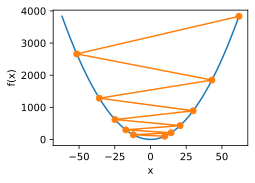

In [8]:
show_trace(gd(1.1))

### 7.2.3 多维梯度下降
我们再考虑一种更广义的情况：目标函数的输入为向量，输出为标量。

假设目标函数$f: \mathbb{R}^d \rightarrow \mathbb{R}$的输入是一个$d$维向量$\boldsymbol{x} = [x_1, x_2, \ldots, x_d]^\top$。目标函数$f(\boldsymbol{x})$有关$\boldsymbol{x}$的梯度是一个由$d$个偏导数组成的向量：
+ $\displaystyle\nabla_{\boldsymbol{x}} f(\boldsymbol{x}) = \bigg[\frac{\partial f(\boldsymbol{x})}{\partial x_1}, \frac{\partial f(\boldsymbol{x})}{\partial x_2}, \ldots, \frac{\partial f(\boldsymbol{x})}{\partial x_d}\bigg]^\top$

为表示简洁，我们用$\nabla f(\boldsymbol{x})$代替$\nabla_{\boldsymbol{x}} f(\boldsymbol{x})$。梯度中每个偏导数元素$\partial f(\boldsymbol{x})/\partial x_i$代表着$f$在$\boldsymbol{x}$有关输入$x_i$的变化率。为了测量$f$沿着单位向量$\boldsymbol{u}$(即$|\boldsymbol{u}|=1$)方向上的变化率，在多元微积分中，我们定义$f$在$\boldsymbol{x}$上沿着$\boldsymbol{u}$方向的方向导数为
+ $\displaystyle\text{D}{\boldsymbol{u}} f(\boldsymbol{x}) = \lim{h \rightarrow 0} \frac{f(\boldsymbol{x} + h \boldsymbol{u}) - f(\boldsymbol{x})}{h}$

依据方向导数性质，以上方向导数可以改写为
+ $\displaystyle\text{D}_{\boldsymbol{u}} f(\boldsymbol{x}) = \nabla f(\boldsymbol{x}) \cdot \boldsymbol{u}$

方向导数$\text{D}{\boldsymbol{u}} f(\boldsymbol{x})$给出了$f$在$\boldsymbol{x}$上沿着所有可能方向的变化率。为了最小化$f$，我们希望找到$f$能被降低最快的方向。因此，我们可以通过单位向量$\boldsymbol{u}$来最小化方向导数$\text{D}{\boldsymbol{u}} f(\boldsymbol{x})$。

由于$\text{D}{\boldsymbol{u}} f(\boldsymbol{x}) = |\nabla f(\boldsymbol{x})| \cdot |\boldsymbol{u}| \cdot \text{cos} (\theta) = |\nabla f(\boldsymbol{x})| \cdot \text{cos} (\theta)$， 其中$\theta$为梯度$\nabla f(\boldsymbol{x})$和单位向量$\boldsymbol{u}$之间的夹角，当$\theta = \pi$时，$\text{cos}(\theta)$取得最小值$-1$。因此，当$\boldsymbol{u}$在梯度方向$\nabla f(\boldsymbol{x})$的相反方向时，方向导数$\text{D}{\boldsymbol{u}} f(\boldsymbol{x})$被最小化。因此，我们可能通过梯度下降算法来不断降低目标函数$f$的值：
+ $\boldsymbol{x} \leftarrow \boldsymbol{x} - \eta \nabla f(\boldsymbol{x})$

其中$\eta$(取正数)称作学习率。

下面我们构造一个输入为二维向量$\boldsymbol{x} = [x_1, x_2]^\top$和输出为标量的目标函数$f(\boldsymbol{x})=x_1^2+2x_2^2$。那么，梯度$\nabla f(\boldsymbol{x}) = [2x_1, 4x_2]^\top$。我们将观察梯度下降从初始位置$[-5,-2]$开始对自变量$\boldsymbol{x}$的迭代轨迹。我们先定义两个辅助函数，第一个函数使用给定的自变量更新函数，从初始位置$[-5,-2]$开始迭代自变量$\boldsymbol{x}$共20次，第二个函数对自变量$\boldsymbol{x}$的迭代轨迹进行可视化。

In [9]:
def train_2d(trainer): # 本函数将保存在d2lzh包中⽅便以后使⽤
    x1, x2, s1, s2 = -5, -2, 0, 0 # s1和s2是⾃变量状态，本章后续⼏节会使⽤ 
    results = [(x1, x2)] 
    for i in range(20):
        x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print('epoch %d, x1 %f, x2 %f' % (i + 1, x1, x2)) 
    return results

def show_trace_2d(f, results): # 本函数将保存在d2lzh包中⽅便以后使⽤ 
    d2l.plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = np.meshgrid(np.arange(-5.5, 1.0, 0.1), np.arange(-3.0, 1.0, 0.1))
    d2l.plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    d2l.plt.xlabel('x1') 
    d2l.plt.ylabel('x2')
    plt.show()

观察学习率为$0.1$时自变量的迭代轨迹。使用梯度下降对自变量$\boldsymbol{x}$迭代20次后，可见最终$\boldsymbol{x}$的值较接近最优解$[0,0]$。

epoch 20, x1 -0.057646, x2 -0.000073


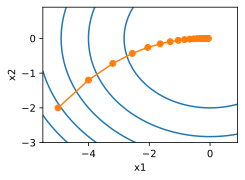

In [10]:
eta = 0.1

def f_2d(x1, x2): # ⽬标函数 
    return x1 ** 2 + 2 * x2 ** 2

def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 2 * x1, x2 - eta * 4 * x2, 0, 0)

show_trace_2d(f_2d, train_2d(gd_2d))

### 7.2.4 随机梯度下降
在深度学习里，目标函数通常是训练数据集中有关各个样本的损失函数的平均。

设$f_i(\boldsymbol{x})$是有关索引为$i$的训练数据样本的损失函数，$n$是训练数据样本数，$\boldsymbol{x}$是模型的参数向量，那么目标函数定义为
+ $\displaystyle f(\boldsymbol{x}) = \frac{1}{n} \sum_{i = 1}^n f_i(\boldsymbol{x})$

目标函数在$\boldsymbol{x}$处的梯度计算为
+ $\displaystyle \nabla f(\boldsymbol{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\boldsymbol{x})$

如果使用梯度下降，每次自变量迭代的计算开销为$\mathcal{O}(n)$，它随着$n$线性增长。因此，当训练数据样本数很大时，梯度下降每次迭代的计算开销很高。

随机梯度下降(stochastic gradient descent，SGD)减少了每次迭代的计算开销。在随机梯度下降的每次迭代中，我们随机均匀采样的一个样本索引$i\in{1,\ldots,n}$，并计算梯度$\nabla f_i(\boldsymbol{x})$来迭代$\boldsymbol{x}$：
+ $\boldsymbol{x} \leftarrow \boldsymbol{x} - \eta \nabla f_i(\boldsymbol{x})$

这里$\eta$同样是学习率。可以看到，每次迭代的计算开销从梯度下降的$\mathcal{O}(n)$降到了常数$\mathcal{O}(1)$。

值得强调的是，随机梯度$\nabla f_i(\boldsymbol{x})$是对梯度$\nabla f(\boldsymbol{x})$的无偏估计：
+ $\displaystyle E_i \nabla f_i(\boldsymbol{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\boldsymbol{x}) = \nabla f(\boldsymbol{x})$

这意味着，平均来说，随机梯度是对梯度的一个良好的估计。

下面我们通过在梯度中添加均值为0的随机噪声来模拟随机梯度下降，以此来比较它与梯度下降的区别。

epoch 20, x1 -0.241657, x2 -0.047646


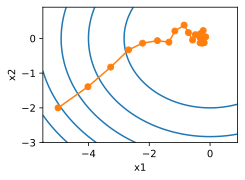

In [11]:
def sgd_2d(x1, x2, s1, s2):
    return (x1 - eta * (2 * x1 + np.random.normal(0.1)), x2 - eta * (4 * x2 + np.random.normal(0.1)), 0, 0)

show_trace_2d(f_2d, train_2d(sgd_2d))

可以看到，随机梯度下降中⾃变量的迭代轨迹相对于梯度下降中的来说更为曲折。这是由于实验所添加的噪声使模拟的随机梯度的准确度下降。在实际中，这些噪声通常指训练数据集中的⽆意义的⼲扰。

## 7.3 小批量随机梯度下降
在每一次迭代中，梯度下降使用整个训练数据集来计算梯度，因此它有时也被称为`批量梯度下降`(batch gradient descent)。而随机梯度下降在每次迭代中只随机采样一个样本来计算梯度。我们还可以在每轮迭代中随机均匀采样多个样本来组成一个小批量，然后使用这个小批量来计算梯度。

设目标函数$f(\boldsymbol{x}): \mathbb{R}^d \rightarrow \mathbb{R}$。在迭代开始前的时间步设为0。该时间步的自变量记为$\boldsymbol{x}_0\in \mathbb{R}^d$，通常由随机初始化得到。在接下来的每一个时间步$t>0$中，小批量随机梯度下降随机均匀采样一个由训练数据样本索引组成的小批量$\mathcal{B}_t$。我们可以通过`重复采样`(sampling with replacement)或者`不重复采样`(sampling without replacement)得到一个小批量中的各个样本。前者允许同一个小批量中出现重复的样本，后者则不允许如此，且更常见。对于这两者间的任一种方式，都可以使用
+ $\displaystyle\boldsymbol{g}_t \leftarrow \nabla f_{\mathcal{B}_t}(\boldsymbol{x}_{t-1}) = \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t}\nabla f_i(\boldsymbol{x}_{t-1})$

来计算时间步$t$的小批量$\mathcal{B}_t$上目标函数位于$\boldsymbol{x}_{t-1}$处的梯度$\boldsymbol{g}_t$。这里$|\mathcal{B}|$代表批量大小，即小批量中样本的个数，是一个超参数。同随机梯度一样，重复采样所得的小批量随机梯度$\boldsymbol{g}_t$也是对梯度$\nabla f(\boldsymbol{x}_{t-1})$的无偏估计。给定学习率$\eta_t$(取正数)，小批量随机梯度下降对自变量的迭代如下：
+ $\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \eta_t \boldsymbol{g}_t$

基于随机采样得到的梯度的方差在迭代过程中无法减小，因此在实际中，(小批量)随机梯度下降的学习率可以在迭代过程中自我衰减，例如$\eta_t=\eta t^\alpha$(通常$\alpha=-1$或者$-0.5$)、$\eta_t = \eta \alpha^t$(如$\alpha=0.95$)或者每迭代若干次后将学习率衰减一次。如此一来，学习率和(小批量)随机梯度乘积的方差会减小。而梯度下降在迭代过程中一直使用目标函数的真实梯度，无须自我衰减学习率。

小批量随机梯度下降中每次迭代的计算开销为$\mathcal{O}(|\mathcal{B}|)$。当批量大小为1时，该算法即随机梯度下降；当批量大小等于训练数据样本数时，该算法即梯度下降。当批量较小时，每次迭代中使用的样本少，这会导致并行处理和内存使用效率变低。这使得在计算同样数目样本的情况下比使用更大批量时所花时间更多。当批量较大时，每个小批量梯度里可能含有更多的冗余信息。为了得到较好的解，批量较大时比批量较小时需要计算的样本数目可能更多，例如增大迭代周期数。

### 7.3.1 读取数据集
本章里我们将使用一个来自NASA的测试不同飞机机翼噪音的数据集来比较各个优化算法。我们使用该数据集的前1500个样本和5个特征，并使用标准化对数据进行预处理。

In [12]:
def get_nasa_data():
    data = np.genfromtxt('./data/nasa.dat', delimiter='\t') 
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    return nd.array(data[:1500, :-1]), nd.array(data[:1500, -1])

features, labels = get_nasa_data() 
features.shape, labels.shape

((1500, 5), (1500,))

### 7.3.2 从零开始实现
`线性回归的从零开始实现`一节中已经实现过小批量随机梯度下降算法。我们在这里将它变得更加通用。具体来说，我们添加了一个状态输入`states`并将超参数放在字典`hyperparams`里。此外，我们将在训练函数里对各个小批量样本的损失求平均，因此优化算法里的梯度不需要除以批量大小。

In [13]:
def sgd(params, states, hyperparams):
    for p in params:
        p[:] -= hyperparams['lr'] * p.grad

下面实现一个通用的训练函数，以方便本章后面介绍的其他优化算法使用。它初始化一个线性回归模型，然后可以使用小批量随机梯度下降以及后续介绍的其它算法来训练模型。

In [14]:
# 本函数已保存在d2lzh包中⽅便以后使⽤
def train_ch7(trainer_fn, states, hyperparams, features, labels, batch_size=10, num_epochs=2):
    # 初始化模型
    net, loss = d2l.linreg, d2l.squared_loss
    w = nd.random.normal(scale=0.01, shape=(features.shape[1], 1))
    b = nd.zeros(1) 
    w.attach_grad()
    b.attach_grad()

    def eval_loss():
        return loss(net(features, w, b), labels).mean().asscalar()

    ls = [eval_loss()] 
    data_iter = gdata.DataLoader(gdata.ArrayDataset(features, labels), batch_size, shuffle=True) 
    
    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            with autograd.record():
                l = loss(net(X, w, b), y).mean() # 使⽤平均损失
            l.backward()
            trainer_fn([w, b], states, hyperparams) # 迭代模型参数
            if (batch_i + 1) * batch_size % 100 == 0: 
                ls.append(eval_loss()) # 每100个样本记录下当前训练误差 
    # 打印结果和作图 
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start)) 
    d2l.set_figsize() 
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls) 
    d2l.plt.xlabel('epoch') 
    d2l.plt.ylabel('loss')
    plt.show()

当批量大小为样本总数1,500时，优化使用的是梯度下降。梯度下降的1个迭代周期对模型参数只迭代1次。可以看到6次迭代后目标函数值(训练损失)的下降趋向了平稳。

loss: 0.246095, 0.022515 sec per epoch


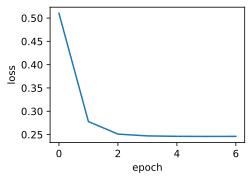

In [15]:
def train_sgd(lr, batch_size, num_epochs=2):
    train_ch7(sgd, None, {'lr': lr}, features, labels, batch_size, num_epochs)

train_sgd(1, 1500, 6)

当批量大小为1时，优化使用的是随机梯度下降。为了简化实现，在(小批量)随机梯度下降的实验中，我们未对学习率进行自我衰减，而是直接采用较小的常数学习率。随机梯度下降中，每处理一个样本会更新一次自变量(模型参数)，一个迭代周期里会对自变量进行1500次更新。可以看到，目标函数值的下降在1个迭代周期后就变得较为平缓。

loss: 0.247127, 2.293882 sec per epoch


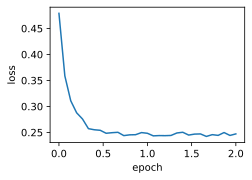

In [16]:
train_sgd(0.005, 1)

虽然随机梯度下降和梯度下降在一个迭代周期里都处理了1500个样本，但随机梯度下降的一个迭代周期耗时更多。这是因为随机梯度下降在一个迭代周期里做了更多次的自变量迭代，而且单样本的梯度计算难以有效利用矢量计算。

当批量大小为10时，优化使用的是小批量随机梯度下降。它在每个迭代周期的耗时介于梯度下降和随机梯度下降的耗时之间。

loss: 0.242959, 0.255916 sec per epoch


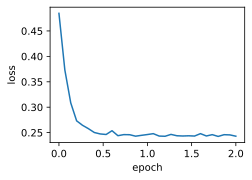

In [17]:
train_sgd(0.05, 10)

### 7.3.3 简洁实现
在`Gluon`里可以通过创建`Trainer`实例来调用优化算法。

In [18]:
# 本函数已保存在d2lzh包中⽅便以后使⽤
def train_gluon_ch7(trainer_name, trainer_hyperparams, features, labels, batch_size=10, num_epochs=2):
    # 初始化模型 
    net = nn.Sequential() 
    net.add(nn.Dense(1)) 
    net.initialize(init.Normal(sigma=0.01)) 
    loss = gloss.L2Loss()

    def eval_loss():
        return loss(net(features), labels).mean().asscalar()

    ls = [eval_loss()] 
    data_iter = gdata.DataLoader(gdata.ArrayDataset(features, labels), batch_size, shuffle=True) 
    # 创建Trainer实例来迭代模型参数 t
    trainer = gluon.Trainer(net.collect_params(), trainer_name, trainer_hyperparams)
    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size) # 在Trainer实例⾥做梯度平均
            if (batch_i + 1) * batch_size % 100 == 0: 
                ls.append(eval_loss()) 
    # 打印结果和作图 
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start)) 
    d2l.set_figsize() 
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls) 
    d2l.plt.xlabel('epoch') 
    d2l.plt.ylabel('loss')
    plt.show()

loss: 0.242129, 0.229733 sec per epoch


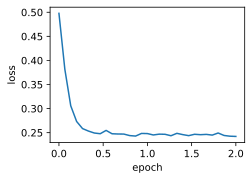

In [19]:
train_gluon_ch7('sgd', {'learning_rate': 0.05}, features, labels, 10)

## 7.4 动量法
在`梯度下降和随机梯度下降`一节中我们提到，目标函数有关自变量的梯度代表了目标函数在自变量当前位置下降最快的方向。因此，梯度下降也叫作最陡下降(steepest descent)。在每次迭代中，梯度下降根据自变量当前位置，沿着当前位置的梯度更新自变量。然而，如果自变量的迭代方向仅仅取决于自变量当前位置，这可能会带来一些问题。

### 7.4.1 梯度下降的问题
让我们考虑一个输入和输出分别为二维向量$\boldsymbol{x} = [x_1, x_2]^\top$和标量的目标函数$f(\boldsymbol{x})=0.1x_1^2+2x_2^2$。与`梯度下降和随机梯度下降`一节中不同，这里将$x_1^2$系数从$1$减小到了$0.1$。下面实现基于这个目标函数的梯度下降，并演示使用学习率为$0.4$时自变量的迭代轨迹。

epoch 20, x1 -0.943467, x2 -0.000073


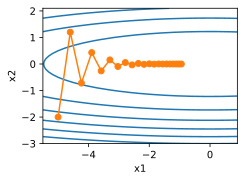

In [20]:
eta = 0.4

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0)

d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

可以看到，同一位置上，目标函数在竖直方向($x_2$轴)比在水平方向的斜率的绝对值更大。因此，给定学习率，梯度下降迭代自变量时会使自变量在竖直方向比在水平方向移动幅度更大。我们需要一个较小的学习率从而避免自变量在竖直方向上越过目标函数最优解。然而，这会造成自变量在水平方向上朝最优解移动变慢。

下面我们试着将学习率调得稍大一点，此时自变量在竖直方向不断越过最优解并逐渐发散。

epoch 20, x1 -0.387814, x2 -1673.365109


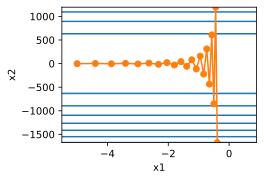

In [21]:
eta = 0.6
d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

### 7.4.2 动量法
动量法的提出是为了解决梯度下降的上述问题。由于小批量随机梯度下降比梯度下降更为广义，本章后续讨论将沿用`小批量随机梯度下降`一节中时间步$t$的小批量随机梯度$\boldsymbol{g}_t$的定义。设时间步$t$的自变量为$\boldsymbol{x}_t$，学习率为$\eta_t$。 在时间步$0$，动量法创建速度变量$\boldsymbol{v}_0$，并将其元素初始化成0。在时间步$t>0$，动量法对每次迭代的步骤做如下修改：
$$\displaystyle\begin{aligned} \boldsymbol{v}_t &\leftarrow \gamma \boldsymbol{v}_{t-1} + \eta_t \boldsymbol{g}_t, \\ \boldsymbol{x}_t &\leftarrow \boldsymbol{x}_{t-1} - \boldsymbol{v}_t\end{aligned} $$

其中，动量超参数$\gamma$满足$0 \leq \gamma < 1$。当$\gamma=0$时，动量法等价于小批量随机梯度下降。

在解释动量法的数学原理前，让我们先从实验中观察梯度下降在使用动量法后的迭代轨迹。

epoch 20, x1 -0.062843, x2 0.001202


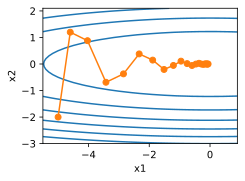

In [22]:
def momentum_2d(x1, x2, v1, v2):
    v1 = gamma * v1 + eta * 0.2 * x1 
    v2 = gamma * v2 + eta * 4 * x2 
    return x1 - v1, x2 - v2, v1, v2

eta, gamma = 0.4, 0.5 
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

可以看到使用较小的学习率$\eta=0.4$和动量超参数$\gamma=0.5$时，动量法在竖直方向上的移动更加平滑，且在水平方向上更快逼近最优解。下面使用较大的学习率$\eta=0.6$，此时自变量也不再发散。

epoch 20, x1 0.007188, x2 0.002553


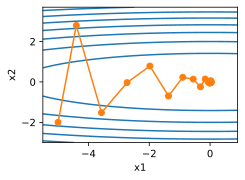

In [23]:
eta = 0.6
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

##### 指数加权移动平均
为了从数学上理解动量法，让我们先解释一下`指数加权移动平均`。给定超参数$0 \leq \gamma < 1$，当前时间步$t$的变量$y_t$是上一时间步$t-1$的变量$y_{t-1}$和当前时间步另一变量$x_t$的线性组合：
+ $y_t = \gamma y_{t-1} + (1-\gamma) x_t$

我们可以对$y_t$展开：
$$\displaystyle\begin{aligned} y_t &= (1-\gamma) x_t + \gamma y_{t-1}\\ &= (1-\gamma)x_t + (1-\gamma) \cdot \gamma x_{t-1} + \gamma^2y_{t-2}\\ &= (1-\gamma)x_t + (1-\gamma) \cdot \gamma x_{t-1} + (1-\gamma) \cdot \gamma^2x_{t-2} + \gamma^3y_{t-3}\\ &\ldots \end{aligned}$$

令$\displaystyle n = \frac{1}{(1-\gamma)}$，那么$\displaystyle \left(1-\frac{1}{n}\right)^n = \gamma^{\frac{1}{(1-\gamma)}}$。因为
+ $\displaystyle\lim_{n \rightarrow \infty} \left(1-\frac{1}{n}\right)^n = \exp(-1) \approx 0.3679$

所以当$\gamma \rightarrow 1$时，$\displaystyle\gamma^{\frac{1}{(1-\gamma)}}=\exp(-1)$，如$0.95^{20} \approx \exp(-1)$。如果把$\exp(-1)$当作一个比较小的数，我们可以在近似中忽略所有含$\displaystyle\gamma^{\frac{1}{(1-\gamma)}}$和比$\displaystyle\gamma^{\frac{1}{(1-\gamma)}}$更高阶的系数的项。例如，当$\gamma=0.95$时，
+ $\displaystyle y_t \approx 0.05 \sum_{i=0}^{19} 0.95^i x_{t-i}$

因此，在实际中，我们常常将$y_t$看作是对最近$\displaystyle\frac{1}{(1-\gamma)}$个时间步的$x_t$值的加权平均。例如，当$\gamma = 0.95$时，$y_t$可以被看作对最近20个时间步的$x_t$值的加权平均；当$\gamma = 0.9$时，$y_t$可以看作是对最近10个时间步的$x_t$值的加权平均。而且，离当前时间步$t$越近的$x_t$值获得的权重越大(越接近1)。

##### 由指数加权移动平均理解动量法
现在，我们对动量法的速度变量做变形：
+ $\displaystyle\boldsymbol{v}_t \leftarrow \gamma \boldsymbol{v}_{t-1} + (1 - \gamma) \left(\frac{\eta_t}{1 - \gamma} \boldsymbol{g}_t\right)$

由指数加权移动平均的形式可得，速度变量$\boldsymbol{v}_t$实际上对序列$\displaystyle {\frac{\eta_{t-i}}{(1-\gamma)}\boldsymbol{g}_{t-i}:i=0,\ldots,\frac{1}{(1-\gamma)}-1}$做了指数加权移动平均。换句话说，相比于小批量随机梯度下降，动量法在每个时间步的自变量更新量近似于将前者对应的最近$\displaystyle \frac{1}{(1-\gamma)}$个时间步的更新量做了指数加权移动平均后再除以$1-\gamma$。所以，在动量法中，自变量在各个方向上的移动幅度不仅取决于当前梯度，还取决于过去的各个梯度在各个方向上是否一致。在本节之前示例的优化问题中，所有梯度在水平方向上为正(向右)，而在竖直方向上时正(向上)时负(向下)。这样，我们就可以使用较大的学习率，从而使自变量向最优解更快移动。


### 7.4.3 从零开始实现
相对于小批量随机梯度下降，动量法需要对每一个自变量维护一个同它一样形状的速度变量，且超参数里多了动量超参数。实现中，我们将速度变量用更广义的状态变量`states`表示。

In [24]:
features, labels = get_nasa_data()

def init_momentum_states():
    v_w = nd.zeros((features.shape[1], 1)) 
    v_b = nd.zeros(1) 
    return (v_w, v_b)

def sgd_momentum(params, states, hyperparams):
    for p, v in zip(params, states):
        v[:] = hyperparams['momentum'] * v + hyperparams['lr'] * p.grad
        p[:] -= v

我们先将动量超参数`momentum`设0.5，这时可以看成是特殊的小批量随机梯度下降：其小批量随机梯度为最近2个时间步的2倍小批量梯度的加权平均。

loss: 0.242622, 0.328388 sec per epoch


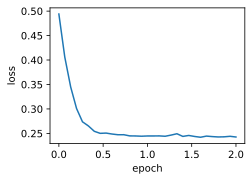

In [25]:
d2l.train_ch7(sgd_momentum, init_momentum_states(), {'lr': 0.02, 'momentum': 0.5}, features, labels)

将动量超参数`momentum`增大到0.9，这时依然可以看成是特殊的小批量随机梯度下降：其小批量随机梯度为最近10个时间步的10倍小批量梯度的加权平均。我们先保持学习率0.02不变。

loss: 0.284474, 0.328143 sec per epoch


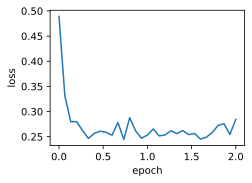

In [26]:
d2l.train_ch7(sgd_momentum, init_momentum_states(), {'lr': 0.02, 'momentum': 0.9}, features, labels)

可见目标函数值在后期迭代过程中的变化不够平滑。直觉上，10倍小批量梯度比2倍小批量梯度大了5倍，我们可以试着将学习率减小到原来的1/5。此时目标函数值在下降了一段时间后变化更加平滑。

loss: 0.245149, 0.330487 sec per epoch


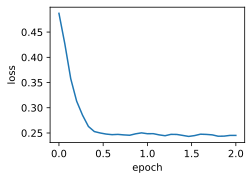

In [27]:
d2l.train_ch7(sgd_momentum, init_momentum_states(), {'lr': 0.004, 'momentum': 0.9}, features, labels)

### 7.4.4 简洁实现
在`Gluon`中，只需要在`Trainer`实例中通过`momentum`来指定动量超参数即可使用动量法。

loss: 0.242711, 0.235771 sec per epoch


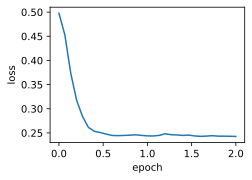

In [28]:
d2l.train_gluon_ch7('sgd', {'learning_rate': 0.004, 'momentum': 0.9}, features, labels)

## 7.5 AdaGrad算法
在之前介绍过的优化算法中，目标函数自变量的每一个元素在相同时间步都使用同一个学习率来自我迭代。举个例子，假设目标函数为$f$，自变量为一个二维向量$[x_1, x_2]^\top$，该向量中每一个元素在迭代时都使用相同的学习率。例如，在学习率为$\eta$的梯度下降中，元素$x_1$和$x_2$都使用相同的学习率$\eta$来自我迭代：
+ $ x_1 \leftarrow x_1 - \eta \frac{\partial{f}}{\partial{x_1}}, \quad x_2 \leftarrow x_2 - \eta \frac{\partial{f}}{\partial{x_2}}$

在`动量法`一节里我们看到，当$x_1$和$x_2$的梯度值有较大差别时，需要选择足够小的学习率使得自变量在梯度值较大的维度上不发散。但这样会导致自变量在梯度值较小的维度上迭代过慢。动量法依赖指数加权移动平均使得自变量的更新方向更加一致，从而降低发散的可能。

本节介绍AdaGrad算法，它根据自变量在每个维度的梯度值的大小来调整各个维度上的学习率，从而避免统一的学习率难以适应所有维度的问题。

### 7.5.1 算法
AdaGrad算法会使用一个小批量随机梯度$\boldsymbol{g}_t$按元素平方的累加变量$\boldsymbol{s}_t$。在时间步0，AdaGrad将$\boldsymbol{s}_0$中每个元素初始化为0。在时间步$t$，首先将小批量随机梯度$\boldsymbol{g}_t$按元素平方后累加到变量$\boldsymbol{s}_t$：
+ $\displaystyle\boldsymbol{s}_t \leftarrow \boldsymbol{s}_{t-1} + \boldsymbol{g}_t \odot \boldsymbol{g}_t$

其中$\odot$是按元素相乘。接着，我们将目标函数自变量中每个元素的学习率通过按元素运算重新调整一下：
+ $\displaystyle\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \frac{\eta}{\sqrt{\boldsymbol{s}_t + \epsilon}} \odot \boldsymbol{g}_t$

其中$\eta$是学习率，$\epsilon$是为了维持数值稳定性而添加的常数，如$10^{-6}$。这里开方、除法和乘法的运算都是按元素运算的。这些按元素运算使得目标函数自变量中每个元素都分别拥有自己的学习率。

### 7.5.2 特点
需要强调的是，小批量随机梯度按元素平方的累加变量$\boldsymbol{s}_t$出现在学习率的分母项中。因此，如果目标函数有关自变量中某个元素的偏导数一直都较大，那么该元素的学习率将下降较快；反之，如果目标函数有关自变量中某个元素的偏导数一直都较小，那么该元素的学习率将下降较慢。然而，由于$\boldsymbol{s}_t$一直在累加按元素平方的梯度，自变量中每个元素的学习率在迭代过程中一直在降低(或不变)。所以，当学习率在迭代早期降得较快且当前解依然不佳时，AdaGrad算法在迭代后期由于学习率过小，可能较难找到一个有用的解。

下面我们仍然以目标函数$f(\boldsymbol{x})=0.1x_1^2+2x_2^2$为例观察AdaGrad算法对自变量的迭代轨迹。我们实现AdaGrad算法并使用和上一节实验中相同的学习率0.4。可以看到，自变量的迭代轨迹较平滑。但由于$\boldsymbol{s}_t$的累加效果使学习率不断衰减，自变量在迭代后期的移动幅度较小。

epoch 20, x1 -2.382563, x2 -0.158591


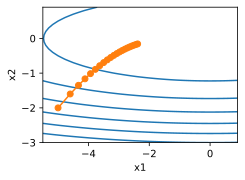

In [29]:
def adagrad_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6    # 前两项为⾃变量梯度
    s1 += g1 ** 2 
    s2 += g2 ** 2 
    x1 -= eta / math.sqrt(s1 + eps) * g1 
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta = 0.4 
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

下⾯将学习率增⼤到2。可以看到⾃变量更为迅速地逼近了最优解。

epoch 20, x1 -0.002295, x2 -0.000000


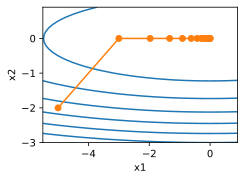

In [30]:
eta = 2 
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

### 7.5.3 从零开始实现
同动量法⼀样，AdaGrad算法需要对每个⾃变量维护同它⼀样形状的状态变量。 我们根据AdaGrad算法中的公式实现该算法。

In [31]:
features, labels = get_nasa_data()

def init_adagrad_states():
    s_w = nd.zeros((features.shape[1], 1)) 
    s_b = nd.zeros(1) 
    return (s_w, s_b)

def adagrad(params, states, hyperparams):
    eps = 1e-6 
    for p, s in zip(params, states):
        s[:] += p.grad.square()
        p[:] -= hyperparams['lr'] * p.grad / (s + eps).sqrt()

与`小批量随机梯度下降`⼀节中的实验相⽐，这⾥使⽤更⼤的学习率来训练模型。

loss: 0.243022, 0.349550 sec per epoch


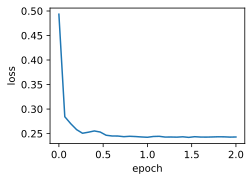

In [32]:
d2l.train_ch7(adagrad, init_adagrad_states(), {'lr': 0.1}, features, labels)

### 7.5.4 简洁实现
通过名称为`adagrad`的`Trainer`实例，我们便可使⽤`Gluon`提供的`AdaGrad`算法来训练模型。

loss: 0.242235, 0.451418 sec per epoch


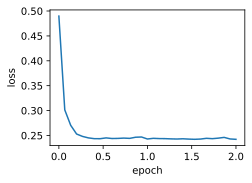

In [33]:
d2l.train_gluon_ch7('adagrad', {'learning_rate': 0.1}, features, labels)

## 7.6 RMSProp算法
我们在`AdaGrad算法`一节中提到，因为调整学习率时分母上的变量$\boldsymbol{s}_t$一直在累加按元素平方的小批量随机梯度，所以目标函数自变量每个元素的学习率在迭代过程中一直在降低(或不变)。因此，当学习率在迭代早期降得较快且当前解依然不佳时，AdaGrad算法在迭代后期由于学习率过小，可能较难找到一个有用的解。为了解决这一问题，RMSProp算法对AdaGrad算法做了一点小小的修改。

### 7.6.1 算法
我们在`动量法`一节里介绍过指数加权移动平均。不同于AdaGrad算法里状态变量$\boldsymbol{s}_t$是截至时间步$t$所有小批量随机梯度$\boldsymbol{g}_t$按元素平方和，RMSProp算法将这些梯度按元素平方做指数加权移动平均。具体来说，给定超参数$0 \leq \gamma < 1$，RMSProp算法在时间步$t>0$计算
+ $\boldsymbol{s}_t \leftarrow \gamma \boldsymbol{s}_{t-1} + (1 - \gamma) \boldsymbol{g}_t \odot \boldsymbol{g}_t$

和AdaGrad算法一样，RMSProp算法将目标函数自变量中每个元素的学习率通过按元素运算重新调整，然后更新自变量
+ $\displaystyle\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \frac{\eta}{\sqrt{\boldsymbol{s}_t + \epsilon}} \odot \boldsymbol{g}_t$

其中$\eta$是学习率，$\epsilon$是为了维持数值稳定性而添加的常数，如$10^{-6}$。因为RMSProp算法的状态变量$\boldsymbol{s}_t$是对平方项$\boldsymbol{g}_t \odot \boldsymbol{g}_t$的指数加权移动平均，所以可以看作最近$\frac{1}{(1-\gamma)}$个时间步的小批量随机梯度平方项的加权平均。如此一来，自变量每个元素的学习率在迭代过程中就不再一直降低(或不变)。

我们观察RMSProp算法对目标函数$f(\boldsymbol{x})=0.1x_1^2+2x_2^2$中自变量的迭代轨迹。回忆在`AdaGrad算法`一节使用的学习率为0.4的AdaGrad算法，自变量在迭代后期的移动幅度较小。但在同样的学习率下，RMSProp算法可以更快逼近最优解。

epoch 20, x1 -0.010599, x2 0.000000


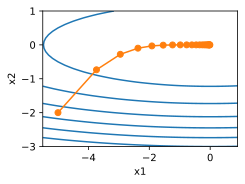

In [34]:
def rmsprop_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 = gamma * s1 + (1 - gamma) * g1 ** 2 
    s2 = gamma * s2 + (1 - gamma) * g2 ** 2 
    x1 -= eta / math.sqrt(s1 + eps) * g1 
    x2 -= eta / math.sqrt(s2 + eps) * g2 
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta, gamma = 0.4, 0.9 
d2l.show_trace_2d(f_2d, d2l.train_2d(rmsprop_2d))

### 7.6.2 从零开始实现
接下来按照RMSProp算法中的公式实现该算法。

In [35]:
features, labels = get_nasa_data()

def init_rmsprop_states():
    s_w = nd.zeros((features.shape[1], 1)) 
    s_b = nd.zeros(1) 
    return (s_w, s_b)

def rmsprop(params, states, hyperparams):
    gamma, eps = hyperparams['gamma'], 1e-6 
    for p, s in zip(params, states):
        s[:] = gamma * s + (1 - gamma) * p.grad.square()
        p[:] -= hyperparams['lr'] * p.grad / (s + eps).sqrt()

我们将初始学习率设为0.01，并将超参数$\gamma$设为0.9。此时，变量$\boldsymbol{s}_t$可看作最近$\frac{1}{(1-0.9)} = 10$个时间步的平方项$\boldsymbol{g}_t \odot \boldsymbol{g}_t$的加权平均。

loss: 0.243038, 0.442096 sec per epoch


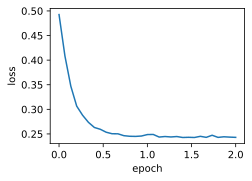

In [36]:
d2l.train_ch7(rmsprop, init_rmsprop_states(), {'lr': 0.01, 'gamma': 0.9}, features, labels)

### 7.6.3 简洁实现
通过名称为`rmsprop`的`Trainer`实例，我们便可使用`Gluon`提供的RMSProp算法来训练模型。注意，超参数$\gamma$通过`gamma1`指定。

loss: 0.243900, 0.245721 sec per epoch


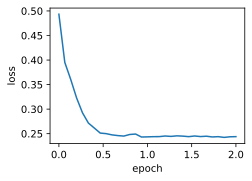

In [37]:
d2l.train_gluon_ch7('rmsprop', {'learning_rate': 0.01, 'gamma1': 0.9}, features, labels)

## 7.7 AdaDelta算法
除了RMSProp算法以外，另一个常用优化算法AdaDelta算法也针对AdaGrad算法在迭代后期可能较难找到有用解的问题做了改进。有意思的是，AdaDelta算法没有学习率这一超参数。

### 7.7.1 算法
AdaDelta算法也像RMSProp算法一样，使用了小批量随机梯度$\boldsymbol{g}_t$按元素平方的指数加权移动平均变量$\boldsymbol{s}_t$。在时间步0，它的所有元素被初始化为0。给定超参数$0 \leq \rho < 1$（对应RMSProp算法中的$\gamma$），在时间步$t>0$，同RMSProp算法一样计算
+ $\boldsymbol{s}_t \leftarrow \rho \boldsymbol{s}_{t-1} + (1 - \rho) \boldsymbol{g}_t \odot \boldsymbol{g}_t$

与RMSProp算法不同的是，AdaDelta算法还维护一个额外的状态变量$\Delta\boldsymbol{x}_t$，其元素同样在时间步0时被初始化为0。我们使用$\Delta\boldsymbol{x}_{t-1}$来计算自变量的变化量：
+ $\displaystyle \boldsymbol{g}_t' \leftarrow \sqrt{\frac{\Delta\boldsymbol{x}_{t-1} + \epsilon}{\boldsymbol{s}_t + \epsilon}} \odot \boldsymbol{g}_t$

其中$\epsilon$是为了维持数值稳定性而添加的常数，如$10^{-5}$。接着更新自变量：
+ $\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \boldsymbol{g}'_t$

最后，我们使用$\Delta\boldsymbol{x}_t$来记录自变量变化量$\boldsymbol{g}'_t$按元素平方的指数加权移动平均：
+ $\Delta\boldsymbol{x}_t \leftarrow \rho \Delta\boldsymbol{x}_{t-1} + (1 - \rho) \boldsymbol{g}'_t \odot \boldsymbol{g}'_t$

可以看到，如不考虑$\epsilon$的影响，AdaDelta算法与RMSProp算法的不同之处在于使用$\displaystyle\sqrt{\Delta\boldsymbol{x}_{t-1}}$来替代超参数$\eta$。

### 7.7.2 从零开始实现
AdaDelta算法需要对每个自变量维护两个状态变量，即$\boldsymbol{s}_t$和$\Delta\boldsymbol{x}_t$。我们按AdaDelta算法中的公式实现该算法。

In [38]:
features, labels = get_nasa_data()

def init_adadelta_states():
    s_w, s_b = nd.zeros((features.shape[1], 1)), nd.zeros(1) 
    delta_w, delta_b = nd.zeros((features.shape[1], 1)), nd.zeros(1) 
    return ((s_w, delta_w), (s_b, delta_b))

def adadelta(params, states, hyperparams):
    rho, eps = hyperparams['rho'], 1e-5
    for p, (s, delta) in zip(params, states):
        s[:] = rho * s + (1 - rho) * p.grad.square() 
        g = ((delta + eps).sqrt() / (s + eps).sqrt()) * p.grad
        p[:] -= g 
        delta[:] = rho * delta + (1 - rho) * g * g

使用超参数$\rho=0.9$来训练模型。

loss: 0.243079, 0.554465 sec per epoch


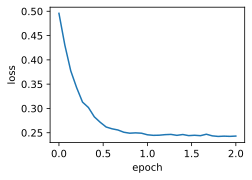

In [39]:
d2l.train_ch7(adadelta, init_adadelta_states(), {'rho': 0.9}, features, labels)

### 7.7.3 简洁实现
通过名称为`adadelta`的`Trainer`实例，我们便可使用Gluon提供的AdaDelta算法。它的超参数可以通过$\rho$来指定。

loss: 0.246010, 0.626413 sec per epoch


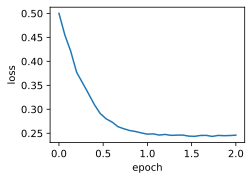

In [40]:
d2l.train_gluon_ch7('adadelta', {'rho': 0.9}, features, labels)

## 7.8 Adam算法
Adam算法在RMSProp算法基础上对小批量随机梯度也做了指数加权移动平均。下面我们来介绍这个算法。

### 7.8.1 算法
Adam算法使用了动量变量$\boldsymbol{v}_t$和RMSProp算法中小批量随机梯度按元素平方的指数加权移动平均变量$\boldsymbol{s}_t$，并在时间步0将它们中每个元素初始化为0。给定超参数$0 \leq \beta_1 < 1$(算法作者建议设为0.9)，时间步$t$的动量变量$\boldsymbol{v}_t$即小批量随机梯度$\boldsymbol{g}_t$的指数加权移动平均：
+ $\displaystyle\boldsymbol{v}_t \leftarrow \beta_1 \boldsymbol{v}_{t-1} + (1 - \beta_1) \boldsymbol{g}_t$

和RMSProp算法中一样，给定超参数$0 \leq \beta_2 < 1$(算法作者建议设为0.999)， 将小批量随机梯度按元素平方后的项$\boldsymbol{g}_t \odot \boldsymbol{g}_t$做指数加权移动平均得到$\boldsymbol{s}_t$：
+ $\displaystyle\boldsymbol{s}_t \leftarrow \beta_2 \boldsymbol{s}_{t-1} + (1 - \beta_2) \boldsymbol{g}_t \odot \boldsymbol{g}_t$

由于我们将$\boldsymbol{v}_0$和$\boldsymbol{s}_0$中的元素都初始化为0，在时间步$t$我们得到$\displaystyle\boldsymbol{v}_t = (1-\beta_1) \sum_{i=1}^t \beta_1^{t-i} \boldsymbol{g}_i$。将过去各时间步小批量随机梯度的权值相加，得到$\displaystyle(1-\beta_1) \sum_{i=1}^t \beta_1^{t-i} = 1 - \beta_1^t$。

需要注意的是，当$t$较小时，过去各时间步小批量随机梯度权值之和会较小。例如，当$\beta_1 = 0.9$时，$\boldsymbol{v}_1 = 0.1\boldsymbol{g}_1$。为了消除这样的影响，对于任意时间步$t$，我们可以将$\boldsymbol{v}_t$再除以$1 - \beta_1^t$，从而使过去各时间步小批量随机梯度权值之和为1。这也叫作偏差修正。在Adam算法中，我们对变量$\boldsymbol{v}_t$和$\boldsymbol{s}_t$均作偏差修正：
$$\displaystyle\hat{\boldsymbol{v}}_t \leftarrow \frac{\boldsymbol{v}_t}{1 - \beta_1^t}, \\ \hat{\boldsymbol{s}}_t \leftarrow \frac{\boldsymbol{s}_t}{1 - \beta_2^t}$$

接下来，Adam算法使用以上偏差修正后的变量$\hat{\boldsymbol{v}}_t$和$\hat{\boldsymbol{s}}_t$，将模型参数中每个元素的学习率通过按元素运算重新调整：
+ $\displaystyle\boldsymbol{g}_t' \leftarrow \frac{\eta \hat{\boldsymbol{v}}_t}{\sqrt{\hat{\boldsymbol{s}}_t} + \epsilon}$

其中$\eta$是学习率，$\epsilon$是为了维持数值稳定性而添加的常数，如$10^{-8}$。和AdaGrad算法、RMSProp算法以及AdaDelta算法一样，目标函数自变量中每个元素都分别拥有自己的学习率。最后，使用$\boldsymbol{g}_t'$迭代自变量：
+ $\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \boldsymbol{g}_t'$

### 7.8.2 从零开始实现
我们按照Adam算法中的公式实现该算法。其中时间步$t$通过hyperparams参数传入adam函数。

In [41]:
features, labels = get_nasa_data()

def init_adam_states():
    v_w, v_b = nd.zeros((features.shape[1], 1)), nd.zeros(1) 
    s_w, s_b = nd.zeros((features.shape[1], 1)), nd.zeros(1) 
    return ((v_w, s_w), (v_b, s_b))

def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6 
    for p, (v, s) in zip(params, states):
        v[:] = beta1 * v + (1 - beta1) * p.grad 
        s[:] = beta2 * s + (1 - beta2) * p.grad.square() 
        v_bias_corr = v / (1 - beta1 ** hyperparams['t']) 
        s_bias_corr = s / (1 - beta2 ** hyperparams['t']) 
        p[:] -= hyperparams['lr'] * v_bias_corr / (s_bias_corr.sqrt() + eps) 
    hyperparams['t'] += 1

使用学习率为0.01的Adam算法来训练模型。

loss: 0.244467, 0.550841 sec per epoch


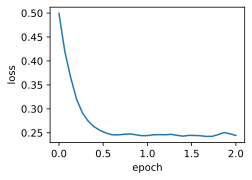

In [42]:
d2l.train_ch7(adam, init_adam_states(), {'lr': 0.01, 't': 1}, features, labels)

### 7.8.3 简洁实现
通过名称为`adam`的`Trainer`实例，我们便可使⽤`Gluon`提供的Adam算法。

loss: 0.242342, 0.247839 sec per epoch


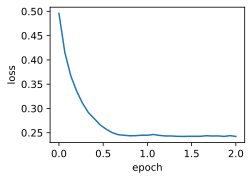

In [43]:
d2l.train_gluon_ch7('adam', {'learning_rate': 0.01}, features, labels)